In [1]:
import os
data_dir = './data/experiments'
data_files = [' '] + os.listdir(data_dir)
#if 'message.npy' in os.listdir():
#    os.remove('message.npy')

# Widget styles
default = (data_files[0], ' ')
style = {'description_width': 'initial'}
features_layout = {'width': 'max-content','height':'200px'}

from IPython.display import display, HTML, clear_output, display_html
from itertools import chain,cycle
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, Layout, HBox, VBox
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None, 'display.max_colwidth', 100)
import numpy as np
import time
import re
import sys
import requests
import subprocess
import numpy as np
from zipfile import ZipFile
import json
import ast
import mysql.connector as mysql

# File selection menu
file_dd=widgets.SelectMultiple(options=data_files,value=default,
    description='File:',style=style,layout=features_layout)
# Service 
service_button = widgets.RadioButtons(
    options=['Local', 'Remote'], value='Local',layout={'width': 'max-content'}, description='Service:',
    disabled=False)
# Analyse button 
run_button = widgets.Button(description = "Cluster",style=style)
run_button.style.button_color = 'lightgreen'
# Metric menues
metrics_layout = {'display':'flex','width': '130px','height':'30px', 'justify_content':'flex-end'}
options = list(np.arange(1,11))
options = [str(o) for o in options]
metrics_optimize = {'min_max_tpc': ('min', 1), 'wcss': ('min', 1), 'bcss': ('max', 1), 'ch_index': ('max', 1),\
'db_index':('min', 1), 'silhouette':('max', 1), 'words_pairs': ('max', 1)}
metrics = list(metrics_optimize.keys())
metrics_menues = {}
for metric in metrics:
    menue=widgets.Dropdown(options=options,value='1',description=metric, layout=metrics_layout)
    metrics_menues[metric]=menue
# Granularity slider
granularity = widgets.IntSlider(value=100, min=2, max=1000, step=1, description='Number of Clusters',\
                                     orientation='horizontal',readout=True, readout_format='d',\
                                     style = {'description_width': 'initial'}, layout=Layout(width='400px'))
apply_granularity = widgets.ToggleButton(value=False, description='Select granularity level?',
    disabled=False, button_style='info', tooltip='Description',
    icon='check', layout=Layout(width='200px'))
# Minimal cluster size
min_cluster_menue=widgets.Dropdown(options=['0']+ options,value='0',\
                       description='Minimum number of tasks in cluster',\
                                   style = {'description_width': 'initial'},\
                                   layout=Layout(width='300px'))

# Service    
service_location = 'Local' # Remote
metrics_optimize = {'min_max_tpc': ('min', 1), 'wcss': ('min', 1), 'bcss': ('max', 1), 'ch_index': ('max', 1),\
'db_index':('min', 1), 'silhouette':('max', 1), 'words_pairs': ('max', 1)}
db_name = 'CAdb'
location_db_params = {'Local': {'host': 'localhost', 'user':'rony', 'password':'exp8546$fs', 'database': db_name},\
                      'Remote': {'host': '172.31.36.11', 'user':'researchUIuser', 'password':'query1234$fs', 'database': db_name}}
conn_params = location_db_params[service_location]
conn = mysql.connect(**conn_params)
c=conn.cursor()
c.execute("SET SESSION TRANSACTION ISOLATION LEVEL READ COMMITTED")
location_url = {'Local': 'http://127.0.0.01:6002/cluster_analysis/api/v0.1/clustering',\
                'Remote': 'http://172.31.36.11/cluster_analysis/api/v0.1/clustering'}
url = location_url[service_location]


def run_service(b):
    file_checkpoints = True
    ## Submitted data files
    files = file_dd.value
    print('files:', files)
    file_types = list(set([t.split('.')[1] for t in files]))
    print('file types:', file_types)
    #Checkpoint: Files submitted
    if files[0][0] == ' ':
        print('No file selected')
        file_checkpoints = False
    #Checkpoint: Zip files
    elif 'zip' in file_types:
        #Checkpoint: One among few files zipped 
        if len(file_types)>1: 
            print('The submitted files include a zip file')
            file_checkpoints = False
        else: 
            data_path = os.path.join(data_dir, files[0])
            files = {'file': open(data_path, 'rb')} 
    #Zip data files 
    else:
        file_paths = []
        for file in files:
            file_paths.append(os.path.join(data_dir, file))
        print('file_paths:', file_paths)
        with ZipFile('zipped_files.zip','w') as zip:
            # writing each file one by one
            for file_path in file_paths:
                zip.write(file_path)
        files = {'file': open('zipped_files.zip', 'rb')}
        os.remove('zipped_files.zip')
    
    if file_checkpoints:
        ## Experiment configuration
        config = {}
        
        # Experiment id
        experiment_ids = pd.read_sql_query("SELECT experiment_id from results", conn).astype(int)
        if len(experiment_ids) == 0: experiment_id = 1
        else: experiment_id = int(max(experiment_ids.values)[0]) + 1

        config['experiment_id'] = experiment_id
        print('experiment_id:', experiment_id)
        
        min_cluster_size = min_cluster_menue.value[0]
        print('min_cluster_size:', min_cluster_size)
        config['min_cluster_size'] = min_cluster_size

        # Metrics weights
        for metric, menue in metrics_menues.items():
            config[metric] = menue.value[0]
        if apply_granularity.value:
            config['num_clusters'] = granularity.value
        
        # Post experiment data and configuration
        response = requests.post(url, files=files, data=config)
        print(response.text)
        if response.text == 'Activity names clustered':
            
            # Show runs results
            display(HTML('<h1 style="color:magenta">Run Scores </h1>'))
            print('Run for experiment {eid}'.format(eid=experiment_id))
            run_cols = ['run_start', 'run_end', 'duration', 'tasks_count']
            runs_df = pd.read_sql_query("SELECT * FROM runs \
            WHERE experiment_id={eid}".format(eid=experiment_id), conn)
            #.drop(run_cols, axis=1)
            display(runs_df)
            
            # Present the best run result
            print('Experiment results')
            result_df = pd.read_sql_query("SELECT * FROM results \
            WHERE experiment_id={eid}".format(eid=experiment_id), conn).drop(run_cols, axis=1)
            display(result_df)
            best_run_id = result_df['run_id'].values[0]
            print('Run id for the best run=', best_run_id)
            print('The clusters for the best run are ready for drill down analysis')
            result = result_df['result'].values[0]
            print('Result')
            print(type(result))
            print(result)

def get_activities(b):
    #clear_output()
    cluster_key = clusters_keys_dd.value
    result = pd.read_sql_query("SELECT Result FROM results", conn).values[0][0]
    result_dict = ast.literal_eval(result)
    clusters = list(ast.literal_eval(result).values())[0]
    ids_names = clusters[cluster_key]
    ids_names = [' '.join(id_name) for id_name in ids_names]
    ids_names = '\n'.join(ids_names)
    with open('ids_names.txt', 'w') as f: f.write(ids_names)
        
def cluster_stats_plots(b):
    #clear_output()
    cluster_key = clusters_keys_dd.value
    names_to_exclude = ids_names_dd.value
    exclude_ids = [i.split(' ')[0] for i in names_to_exclude]
    result = pd.read_sql_query("SELECT Result FROM results", conn).values[0][0]
    result_dict = ast.literal_eval(result)
    clusters = list(ast.literal_eval(result).values())[0]
    # Activities duration values
    ids_names = {i[0]:i[1] for i in clusters[cluster_key] if i[0] not in exclude_ids}
    ids, names = list(ids_names.keys()), list(ids_names.values())
    
    planned_duration_dict = result_dict['planned_duration_vals']
    #print('planned_duration_dict:', planned_duration_dict)
    planned_duration_dict = {k:v for k,v in planned_duration_dict.items() if k in ids}
    #print('planned_duration_dict:', planned_duration_dict)
    planned_duration_vals = list(planned_duration_dict.values())
    #print('planned_duration_vals:', planned_duration_vals)

    actual_duration_dict = result_dict['actual_duration_vals']
    actual_duration_dict = {k:v for k,v in actual_duration_dict.items() if k in ids}
    #print('actual_duration_dict:', actual_duration_dict)
    actual_duration_vals = list(actual_duration_dict.values())
    #print('actual_duration_vals:', actual_duration_vals)

    planned_in_actual_dict = {k:v for k,v in planned_duration_dict.items() if k in actual_duration_dict.keys()}
    #print('planned_in_actual_dict:', planned_in_actual_dict)

    # Duration ratios and overruns
    duration_ratios, tasks_overrun, tasks_overrun_perc = [], [], []
    for id, task_planned_duration in planned_in_actual_dict.items():
        task_actual_duration = actual_duration_dict[id]
        if task_planned_duration != 0:
            duration_ratios.append(round(task_actual_duration/task_planned_duration,2))
            task_overrun = task_actual_duration-task_planned_duration
            tasks_overrun.append(task_overrun)
            tasks_overrun_perc.append(task_overrun/task_planned_duration)

    ## Cluster Statistics
    display(HTML('<h1 style="color:magenta">Cluster RCF Analysis</h1>'))
    print('Cluster Statistics')
    print('Activities in Cluster:', len(ids))
    print('Completed Activities in Cluster:', len(actual_duration_vals))
    # Table
    index = ['Planned Duration(Days)', 'Actual Duration(Days)', 'Overrun(Days)', 'Overrun(%)']
    headers = ['MEAN', 'MEDIAN', 'STD']
    def stats_row(arr): 
        if len(arr)>0:
            return [np.mean(arr), np.median(arr), np.std(arr)]
        else:
            return(np.nan, np.nan, np.nan)
    table_rows = [stats_row(planned_duration_vals), stats_row(actual_duration_vals),\
                 stats_row(tasks_overrun), stats_row(tasks_overrun_perc)]
    stats_df = pd.DataFrame(table_rows, columns=headers, index=index)
    stats_df = round(stats_df, 2)
    #display(stats_df)                

    # Plot Values: RCF for Tasks in Cluster
    # x = percentile,  y = duration_ratios
    duration_ratios.sort()
    sum_ratios = sum(duration_ratios)
    ratios_cumsum = np.cumsum(duration_ratios)
    percentile = 100*(ratios_cumsum/sum_ratios)
    rcf_df = pd.DataFrame(list(zip(percentile, duration_ratios)),\
                          columns = ['Percentile', 'Duration Ratio'])

    # Plot Values: Duration Distribution
    duration_type = len(planned_duration_vals) * ['Planned'] + len(actual_duration_vals) *['Actual']
    duration_vals = list(planned_duration_vals)+list(actual_duration_vals)
    duration_df = pd.DataFrame(list(zip(duration_type, duration_vals)), columns=['Duration', 'Days'])

    # Cluster description
    names_df = pd.DataFrame(ids, columns=['ID'])
    names_df['Name'] = names
    names_df['Planned Duration'] = planned_duration_vals
    names_df['Actual Duration'] = actual_duration_vals

    ## Display
    # Tables
    display_side_by_side(names_df,stats_df, titles=['Tasks in Cluster','Cluster Statistics'])

    # Plots
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))#, sharey=True)
    duration_dist = sns.boxplot(ax=axes[0], x="Duration", y="Days", data=duration_df)
    rcf = sns.lineplot(ax=axes[1], x="Percentile", y="Duration Ratio", data=rcf_df)
    axes[0].set_title('Duration Distibution (Tasks in Cluster)')
    axes[1].set_title('RCF For Tasks in Cluster')

In [2]:
def left_align(df):
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector='th', props=[('text-align', 'left')])]
    )
    return left_aligned_df

def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:right"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        df=left_align(df)
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [3]:
# Dashboard
run_button.on_click(run_service)
display(HTML('<h1 style="color:magenta">Cluster Activities</h1>\
              <p style="color:blue">Use to following menus to submit a file for analysis:</p>\
                 <ul>\
                  <li style="color:magenta">File to analyze</li>\
                  <li style="color:magenta">Select granularity level</li>\
                  <li style="color:magenta">Set weights for validation metrics</li>\
                </ul>'))
file_box = VBox(children=[service_button, file_dd, run_button])
metrics_box = VBox(children=list(metrics_menues.values()))
config_box = VBox(children=[apply_granularity, granularity, min_cluster_menue])
HBox(children=[file_box, config_box, metrics_box])

# Experiment and Run Selection

In [4]:
def get_clusters(b):
    experiment_id = experiments_dd.value
    result_df = pd.read_sql_query("SELECT * FROM results \
    WHERE experiment_id={eid}".format(eid=experiment_id), conn)
    best_run_id = result_df['run_id'].values[0]
    result = pd.read_sql_query("SELECT Result FROM results", conn).values[0][0]
    clusters = list(ast.literal_eval(result).values())[0]
    clusters_keys = list(clusters.keys())
    clusters_keys = '\n'.join(clusters_keys)
    with open('clusters_keys.txt', 'w') as f: f.write(clusters_keys)

In [5]:
display(HTML('<h1 style="color:magenta">Select Experiment and Run </h1>'))
experiment_ids = pd.read_sql_query("SELECT experiment_id FROM results", conn).astype(int)
experiment_ids = list(experiment_ids['experiment_id'].unique())
experiments_dd=widgets.Dropdown(options=experiment_ids, value=experiment_ids[0],
    description='Select Experiment:',style=style, layout={'width': 'max-content'})
clusters_button = widgets.Button(description = "Clusters ",style=style, layout={'width': 'max-content'})
clusters_button.style.button_color = 'lightblue'
clusters_button.on_click(get_clusters)
HBox(children=[experiments_dd, clusters_button])

In [10]:
clusters_keys = open('clusters_keys.txt').read().split('\n')
clusters_keys_dd=widgets.Dropdown(options=clusters_keys, value=clusters_keys[0],
    description='Select Cluster:',style=style, layout={'width': 'max-content'})
button = widgets.Button(description = "Get Tasks",style=style)
button.style.button_color = 'orange'
button.on_click(get_activities)
HBox(children=[clusters_keys_dd, button])

Cluster Statistics
Activities in Cluster: 4
Completed Activities in Cluster: 4


Tasks in Cluster 
 
 
 
   
 ID 
 Name 
 Planned Duration 
 Actual Duration 
 
 
 
 
 0 
 SCWtaBA8 
 BA8 - (1st) BD Consent to Temp works for SCW & Culvert Modification (Resubmit incl wall, excav.& anchor)(Wet){5b1(r)} 
 59 
 60 
 
 
 1 
 GENSUB9A 
 Aluminum - BD Approval 
 29 
 28 
 
 
 2 
 POW_BA58_1 
 BA8 - Consent for Excav & ELS Plan for Power Island Area (Open Cut)(Phase 3){7c2i} 
 29 
 29 
 
 
 3 
 SFF-BA58a 
 BA5 - Resub.of (Type II) Amendment for Zone A Sheet Pile Alternative {4b1-alt A-1} [APPROVED AS TYPE I] 
 89 
 24 
 
 
 
 Cluster Statistics 
 
 
 
   
 MEAN 
 MEDIAN 
 STD 
 
 
 
 
 Planned Duration(Days) 
 51.500000 
 44.000000 
 24.870000 
 
 
 Actual Duration(Days) 
 35.250000 
 28.500000 
 14.410000 
 
 
 Overrun(Days) 
 -16.250000 
 -0.500000 
 28.150000 
 
 
 Overrun(%) 
 -0.190000 
 -0.020000 
 0.310000

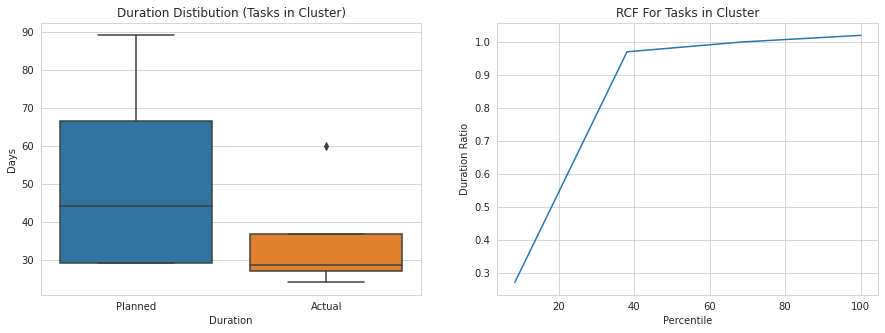

In [13]:
ids_names = [' '] + open('ids_names.txt').read().split('\n')
#ids_names = [(id_name,) for id_name in ids_names]
layout={'width': 'max-content', 'height':'max-content'}
layout=Layout(display="flex", flex_flow='column')
ids_names_dd=widgets.SelectMultiple(options=ids_names, value=(ids_names[0], ' '),
    description='Names to exclude:',style=style, layout=layout)
button = widgets.Button(description = "Run RCF",style=style)
button.style.button_color = 'yellow'
button.on_click(cluster_stats_plots)
HBox(children=[ids_names_dd, button])

In [9]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')